### NOTE: Any code tagged with __"# Personal"__ has a professional, well-tested and  more-optimized implementation in numby and/or scipy.
### I coded it only for fun, and __shall not__ be used in a professional way.

In [1]:
import numpy as np
from numpy.linalg import eig, inv, solve, svd
from scipy.linalg import lu
from scipy.optimize import fsolve

#### Numbers Representation

In [2]:
def bin_to_decimal(bin_num) -> float:
    '''
        INPUT:
            bin_num: int or float or str.
        
        OUTPUT: Decimal result as type float.    
    '''
    bin_num = float(bin_num)
    int_part, frac_part = str(bin_num).split('.')
    
    int_part = int(int_part.replace('0b', ''), 2)
    frac_part = sum([(int(frac_part[i])/2**(i+1)) for i in range(len(frac_part))])
    
    return int_part + frac_part

In [3]:
print(bin_to_decimal(110.101))
print(bin_to_decimal('1010.01'))
print(bin_to_decimal('111.111'))
print(bin_to_decimal(111))

6.625
10.25
7.875
7.0


In [4]:
def decimal_to_bin(num, k=16) -> str:
    '''
        INPUT:
            num: int or float or str.
            k: is precision digits after the floating point (i.e. 0.000k)
        
        OUTPUT: Binary result as type str.    
    '''
    num = float(num)
    int_part, frac_part = str(num).split('.')
    
    int_part = bin(int(int_part))
    
    frac_part = float(f'0.{frac_part}')
    res = ''
    for i in range(k):
        x = 2.0 * frac_part
        if x < 1:
            res += '0'
            frac_part = x
        else:
            res += '1'
            frac_part = x - 1.0
    
    return int_part.replace('0b', '') + '.' + res

In [5]:
print(decimal_to_bin(4.47))
print(decimal_to_bin(5.5))
print(decimal_to_bin(8.75))
print(decimal_to_bin(0.1, k=6))

100.0111100001010001
101.1000000000000000
1000.1100000000000000
0.000110


In [6]:
def _format(num_repr_str) -> str:
    return num_repr_str[:1] + ' ' + num_repr_str[1:16] + ' ' + num_repr_str[16:]


def decimal_to_32_bit_fixed_point_repr(decimal_num) -> str:
    '''
        INPUT:
            num: int or float or str.
        
        OUTPUT: 32-bit fixed-point representation result as type str.    
    '''
    decimal_num = float(decimal_num)
    
    sign_bit = '1' if decimal_num < 0 else '0'
    
    int_part, frac_part = decimal_to_bin(decimal_num).split('.')
    
    int_bits = int_part.rjust(15, '0')
    float_bits = frac_part.ljust(16, '0')
    
    return sign_bit + int_bits + float_bits

In [7]:
print(_format(decimal_to_32_bit_fixed_point_repr(7.875)))
print(_format(decimal_to_32_bit_fixed_point_repr('-0.1')))

0 000000000000111 1110000000000000
1 000000000000000 0001100110011001


In [49]:
def _32_bit_fixed_point_repr_to_decimal(num_repr_str: str) -> float:
    assert len(num_repr_str) == 32, f'Input must be of length 32, your input length is {len(num_repr_str)}'
    sign = num_repr_str[0]
    int_part = num_repr_str[1:16]
    float_part = num_repr_str[16:]
    
    num = bin_to_decimal(float(int_part + '.' + float_part))
    return num if sign == '0' else -num

In [52]:
print(_32_bit_fixed_point_repr_to_decimal('00000000000001111110000000000000'))
print(_32_bit_fixed_point_repr_to_decimal('10000000000000000001100110011001'))
print(_32_bit_fixed_point_repr_to_decimal('10000000100000101000000000000000'))

7.875
-0.0999908447265625
-130.5


#### Guassian Elimination

In [10]:
def guassian_elimination(M):
    m, n = M.shape
    R = M.copy().astype(float)
    for i in range(n-1): # for each column
        for j in range(i+1, m): # for each row
            x = 0.0 if R[i, i] == 0 else -R[j, i] / R[i, i]
            R[j] = R[j] + R[i] * x
            # print(f'Row({j}), Col({i})')
            # print('x = ', x)
            # print('R = ', R)
            
    return R

In [11]:
M = np.array([
    [2 , 4 , -2],
    [4 , 9 , -3],
    [-2, -3, 7 ],
])

guassian_elimination(M)

array([[ 2.,  4., -2.],
       [ 0.,  1.,  1.],
       [ 0.,  0.,  4.]])

#### LU Decomposition

In [53]:
# Personal code (use "lu" function from "scipy.linalg" module, instead).
def decompose_LU(A):
    m, n = A.shape
    U = A.copy().astype(float)
    L = np.eye(m)
    for i in range(n-1): # for each column
        for j in range(i+1, m): # for each row
            x = 0.0 if U[i, i] == 0 else -U[j, i] / U[i, i]
            U[j] = U[j] + U[i] * x
            L[j, i] = -x
            
    return L, U

In [13]:
# Ex 1
A1 = np.array([
    [2, 5],
    [1, 2]
])
y1 = np.array([[21], [8]])


In [14]:
print('LU decomposition (mine) =\n', decompose_LU(A1)) # L, U
print('LU decomposion with scipy =\n', lu(A1)) # P, L, U

LU decomposition (mine) =
 (array([[1. , 0. ],
       [0.5, 1. ]]), array([[ 2. ,  5. ],
       [ 0. , -0.5]]))
LU decomposion with scipy =
 (array([[1., 0.],
       [0., 1.]]), array([[1. , 0. ],
       [0.5, 1. ]]), array([[ 2. ,  5. ],
       [ 0. , -0.5]]))


In [15]:
# Personal (use "solve" function from "np.linalg" module, instead).
def solve_linear_system(A, y):
    return inv(A) @ y

In [59]:
def solve_lu(A, y):
    P, L, U = lu(A)
    # is any rows from A matrix were replaced, adjust (replace the corresponding rows of) y also.
    y_adjusted = inv(P) @ y
    M = solve(L, y_adjusted)
    print('M = ', M)
    return solve(U, M)

solve_lu(A1, y1)

M =  [[21. ]
 [-2.5]]


array([[-2.],
       [ 5.]])

In [60]:
solve_lu(
    np.array([
        [7, -2, 1],
        [14, -7, -3],
        [-7, 11, 18],
    ]),
    np.array([[12], [17], [5]])
)

M =  [[17. ]
 [13.5]
 [ 0.8]]


array([[ 3.],
       [ 4.],
       [-1.]])

In [58]:
lu(np.array([
        [7, -2, 1],
        [14, -7, -3],
        [-7, 11, 18],
    ]))

(array([[0., 0., 1.],
        [1., 0., 0.],
        [0., 1., 0.]]),
 array([[ 1. ,  0. ,  0. ],
        [-0.5,  1. ,  0. ],
        [ 0.5,  0.2,  1. ]]),
 array([[14. , -7. , -3. ],
        [ 0. ,  7.5, 16.5],
        [ 0. ,  0. , -0.8]]))

In [17]:
# Ex 2
A2 = np.array([
    [1, 1, 1 ],
    [4, 3, -1],
    [3, 5, 3 ],
])
y2 = np.array([[1], [6], [4]])

solve_lu(A2, y2)

array([[ 1. ],
       [ 0.5],
       [-0.5]])

#### Jacobi method to solve a linear system of equations.

In [18]:
# A hepler function to compute infinity norm to use in checking conversion.
def inf_norm(V):
    # inf norm of a vector is the max absolute value of its elements.
    return np.abs(V).max()

In [68]:
# Personal
# Brute-force Jacobi (Vectorized)
def jacobi_brute_force(A, y, tol=1e-6, max_iters=20):
    m, n = A.shape
    X = np.zeros(shape=(m, 1))
    X_prev = np.zeros(shape=(m, 1))
    
    # coefficients matrix.
    C = np.c_[-A, y]
    np.fill_diagonal(C, np.diagonal(A))
    
    # Divide each row by its pivot element (the corresponding element of the diagonal of A).
    # to make the pivots coeficients equal 1.
    C = C / np.diagonal(A).reshape(-1, 1)
    
    i = 0
    while i < max_iters:
        X = C @ np.r_[X, np.ones(shape=(1,1))] - X
        print('x =', X)
        if inf_norm(X - X_prev) / inf_norm(X) <= tol:
            print('Conversion at i =' , i)
            break
        
        X_prev = X    
        i += 1
        
    if i == max_iters:
        print('"max_iters" reached before conversion, i =', i)    
    
    return X

In [64]:
def jacobi_decomposition(A, y, tol=1e-6, max_iters=20):
    D = np.diag(np.diag(A))
    L = D - np.tril(A)
    U = D - np.triu(A)
    
    X = np.zeros(shape=(A.shape[0], 1))
    X_prev = np.zeros(shape=(A.shape[0], 1))
    
    D_inv = inv(D)
    
    i = 0
    while i < max_iters:
        X = D_inv @ (L + U) @ X + D_inv @ y
        print('x =', X)
        if inf_norm(X - X_prev) / inf_norm(X) <= tol:
            print('Conversion at i =' , i)
            break
            
        X_prev = X
        i += 1
        
    if i == max_iters:
        print('"max_iters" reached before conversion, i =', i) 
    
    return X

In [74]:
jacobi_brute_force(
    np.array([
        [3,-1,1],
        [3,6,2],
        [3,3,7],
    ]),
    np.array([[1], [0], [4]])
)

x = [[0.33333333]
 [0.        ]
 [0.57142857]]
x = [[ 0.14285714]
 [-0.35714286]
 [ 0.42857143]]
x = [[ 0.07142857]
 [-0.21428571]
 [ 0.66326531]]
x = [[ 0.04081633]
 [-0.25680272]
 [ 0.63265306]]
x = [[ 0.03684807]
 [-0.23129252]
 [ 0.66399417]]
x = [[ 0.03490444]
 [-0.23975543]
 [ 0.6547619 ]]
x = [[ 0.03516089]
 [-0.23570619]
 [ 0.65922185]]
x = [[ 0.03502399]
 [-0.23732106]
 [ 0.65737656]]
x = [[ 0.03510079]
 [-0.23663751]
 [ 0.65812732]]
x = [[ 0.03507839]
 [-0.23692617]
 [ 0.65780145]]
x = [[ 0.03509079]
 [-0.23680635]
 [ 0.65793476]]
x = [[ 0.0350863 ]
 [-0.23685698]
 [ 0.65787809]]
x = [[ 0.03508831]
 [-0.23683585]
 [ 0.65790172]]
x = [[ 0.03508748]
 [-0.23684473]
 [ 0.6578918 ]]
x = [[ 0.03508782]
 [-0.23684101]
 [ 0.65789596]]
x = [[ 0.03508768]
 [-0.23684257]
 [ 0.65789422]]
x = [[ 0.03508774]
 [-0.23684191]
 [ 0.65789495]]
x = [[ 0.03508771]
 [-0.23684219]
 [ 0.65789465]]
Conversion at i = 17


array([[ 0.03508771],
       [-0.23684219],
       [ 0.65789465]])

In [75]:
eig(np.array([[3, 1], [0, 3]]))

(array([3., 3.]),
 array([[ 1.00000000e+00, -1.00000000e+00],
        [ 0.00000000e+00,  6.66133815e-16]]))

In [21]:
# Ex 3
A = np.array([
    [5, -2, 3],
    [-3, 9, 1],
    [2, -1, -7],
])

y = np.array([[-1], [2], [3]])

In [22]:
jacobi_brute_force(A, y)

Conversion at i = 12


array([[ 0.18611987],
       [ 0.33123032],
       [-0.4227129 ]])

In [23]:
jacobi_decomposition(A, y)

Conversion at i = 12


array([[ 0.18611987],
       [ 0.33123032],
       [-0.4227129 ]])

#### Guass-Seidel method to solve a linear system of equations.

In [70]:
# Personal
# Brute force Gauss-Seidel (semi-vectorized).
def guass_seidel_brute_force(A, y, tol=1e-6, max_iters=50):
    m, n = A.shape
    X = np.zeros(shape=(m, 1))
    X_prev = np.zeros(shape=(m, 1))
    
    C = np.c_[-A, y]
    np.fill_diagonal(C, np.diagonal(A))
    
    # Divide each row by its diagonal element to get the coefficients matrix
    C = C / np.diagonal(A).reshape(-1, 1)
    
    i = 0
    while i < max_iters:
        for j in range(len(C)): # for each row
            X[j, 0] = C[j].reshape(1, -1) @ np.r_[X, [[1]]] - X_prev[j, 0]
        print('X =', X)    
        if inf_norm(X - X_prev) / inf_norm(X) <= tol:
            print('Conversion at i =' , i)
            break
            
        X_prev = X
        i += 1
        
    if i == max_iters:
        print('"max_iters" reached before conversion, i =', i)
                
    return X

In [71]:
guass_seidel_brute_force(
    np.array([
        [3,-1,1],
        [3,6,2],
        [3,3,7],
    ]),
    np.array([[1], [0], [4]])
)

X = [[ 0.33333333]
 [-0.16666667]
 [ 0.5       ]]
X = [[ 0.11111111]
 [-0.22222222]
 [ 0.61904762]]
Conversion at i = 1


array([[ 0.11111111],
       [-0.22222222],
       [ 0.61904762]])

In [25]:
# TODO: needs debugging
guass_seidel_brute_force(A, y)

Conversion at i = 1


array([[ 0.16698413],
       [ 0.33432099],
       [-0.42862182]])

In [72]:
def guass_seidel_decomposition(A, y, tol=1e-6, max_iters=10):
    D = np.diag(np.diag(A))
    L, U = D - np.tril(A), D - np.triu(A)
    
    X = np.zeros(shape=(A.shape[0], 1))
    X_prev = np.zeros(shape=(A.shape[0], 1))
    
    DL_inv = inv(D - L)

    i = 0
    while i < max_iters:
        X = DL_inv @ U @ X + DL_inv @ y
        print('X =', X)
        if inf_norm(X - X_prev) / inf_norm(X) <= tol:
            print('Conversion at i =' , i)
            break
            
        X_prev = X
        i += 1
        
    if i == max_iters:
        print('"max_iters" reached before conversion, i =', i)

    return X

In [73]:
guass_seidel_decomposition(np.array([
        [3,-1,1],
        [3,6,2],
        [3,3,7],
    ]),
    np.array([[1], [0], [4]]))

X = [[ 0.33333333]
 [-0.16666667]
 [ 0.5       ]]
X = [[ 0.11111111]
 [-0.22222222]
 [ 0.61904762]]
X = [[ 0.05291005]
 [-0.23280423]
 [ 0.64852608]]
X = [[ 0.03955656]
 [-0.23595364]
 [ 0.65559875]]
X = [[ 0.0361492 ]
 [-0.23660752]
 [ 0.65733928]]
X = [[ 0.03535107]
 [-0.23678863]
 [ 0.65775895]]
X = [[ 0.03515081]
 [-0.23682839]
 [ 0.65786182]]
X = [[ 0.03510326]
 [-0.23683891]
 [ 0.6578867 ]]
X = [[ 0.03509146]
 [-0.2368413 ]
 [ 0.65789279]]
X = [[ 0.03508864]
 [-0.23684191]
 [ 0.65789426]]
"max_iters" reached before conversion, i = 10


array([[ 0.03508864],
       [-0.23684191],
       [ 0.65789426]])

In [27]:
guass_seidel_decomposition(A, y)

Conversion at i = 8


array([[ 0.18611986],
       [ 0.33123028],
       [-0.42271294]])

#### Power method

In [79]:
def power_method(A, tol=1e-6, max_iters=1000):
    m,n = A.shape
    
    X = np.ones(shape=(m, 1))
    X_prev = X.copy()
    
    i = 0
    while i < max_iters:
        Z = A @ X
        X = Z / inf_norm(Z)
        print('X =', X)
        if inf_norm(X - X_prev) <= tol:
            print('Conversion at i =' , i)
            break
        X_prev = X   
        i += 1
        
    if i == max_iters:
        print('"max_iters" reached before conversion, i =', i)
    
    return inf_norm(A @ X), X        

In [90]:
power_method(np.array([[2, 3], [4, 10]]), max_iters=4)

X = [[0.35714286]
 [1.        ]]
X = [[0.325]
 [1.   ]]
X = [[0.32300885]
 [1.        ]]
X = [[0.32288401]
 [1.        ]]
"max_iters" reached before conversion, i = 4


(11.29153605015674,
 array([[0.32288401],
        [1.        ]]))

In [29]:
# A3 = np.array([[0, 2], [2, 3]])    
A4 = np.array([
    [-4, 14, 0],
    [-5, 13, 0],
    [-1, 0 , 2],
])
power_method(A4)

Conversion at i = 18


(6.0000032697440755,
 array([[ 1.        ],
        [ 0.71428595],
        [-0.24999918]]))

In [30]:
# Check results:
eig_vals, eig_vectors = eig(A4)
print('\neig_vals =\n', eig_vals)
print('\neig_vectors =\n', eig_vectors)


eig_vals =
 [2. 6. 3.]

eig_vectors =
 [[ 0.          0.79740048  0.66666667]
 [ 0.          0.56957177  0.33333333]
 [ 1.         -0.19935012 -0.66666667]]


#### Page rank algorithm

##### Use the power method to find the rank of each node in the following graph:
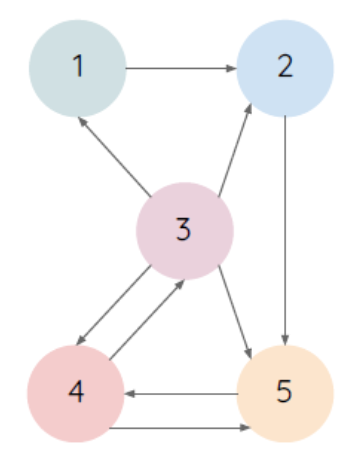


In [85]:
def page_rank(p):
    r = power_method(p)
    return r

In [86]:
page_rank(
    np.array([
        [0,0,1,0.5],
        [1/3,0,0,0],
        [1/3,0.5,0,0.5],
        [1/3,0.5,0,0]
    ])
)

X = [[1.        ]
 [0.22222222]
 [0.88888889]
 [0.55555556]]
X = [[1.        ]
 [0.28571429]
 [0.61904762]
 [0.38095238]]
X = [[1.        ]
 [0.41176471]
 [0.82352941]
 [0.58823529]]
X = [[1.        ]
 [0.29824561]
 [0.74561404]
 [0.48245614]]
X = [[1.        ]
 [0.33777778]
 [0.73333333]
 [0.48888889]]
X = [[1.        ]
 [0.34090909]
 [0.76363636]
 [0.51363636]]
X = [[1.        ]
 [0.32665182]
 [0.74536006]
 [0.49368968]]
X = [[1.        ]
 [0.33595211]
 [0.7493453 ]
 [0.50056117]]
X = [[1.        ]
 [0.33345808]
 [0.75187126]
 [0.50149701]]
X = [[1.        ]
 [0.33246236]
 [0.74884907]
 [0.49875575]]
X = [[1.        ]
 [0.3339254 ]
 [0.75027266]
 [0.50045184]]
X = [[1.        ]
 [0.33316722]
 [0.75014794]
 [0.50004672]]
X = [[1.        ]
 [0.33327624]
 [0.74981186]
 [0.49983132]]
X = [[1.        ]
 [0.33342418]
 [0.7500915 ]
 [0.50010772]]
X = [[1.        ]
 [0.33328489]
 [0.74999027]
 [0.49997275]]
X = [[1.        ]
 [0.33334112]
 [0.74997967]
 [0.49998746]]
X = [[1.        ]
 [0.33

(0.9999996552906272,
 array([[1.        ],
        [0.33333327],
        [0.74999976],
        [0.49999979]]))

In [32]:
p = np.array([
    [0, 0, 0.25, 0  , 0],
    [1, 0, 0.25, 0  , 0],
    [0, 0, 0.0 , 0.5, 0],
    [0, 0, 0.25, 0  , 1],
    [0, 1, 0.25, 0.5, 0],
])

page_rank(p)

Conversion at i = 34


(0.9999997792495962,
 array([[0.12500004],
        [0.24999992],
        [0.49999978],
        [1.        ],
        [0.87499983]]))

### SVD 

##### pseudo inverse with SVD 

In [33]:
# Personal
# use "pinv" function from "np.linalg" module, instead.
def pseudo_inverse(A):
    m, n = A.shape
    
    U, singular_vals, VT = svd(A)
    V = VT.T
    D_inv = np.zeros(shape=(n, m))
    np.fill_diagonal(D_inv, 1/singular_vals)
    
    return V @ D_inv @ U.T

In [34]:
A5 = np.array([
    [7, 2],
    [3, 4],
    [5, 3],
])

A5_inv = pseudo_inverse(A5)
print('pseudo_inverse(A) =\n', A5_inv)
print('pinv with numby =\n', np.linalg.pinv(A5))

pseudo_inverse(A) =
 [[ 0.16666667 -0.10606061  0.03030303]
 [-0.16666667  0.28787879  0.06060606]]
pinv with numby =
 [[ 0.16666667 -0.10606061  0.03030303]
 [-0.16666667  0.28787879  0.06060606]]


In [35]:
# Check result by A @ A_inv
print('\nA_inv @ A = ', A5_inv @ A5)
print('\nA @ A_inv = ', A5 @ A5_inv) # Note that it does not result an Identity matrix


A_inv @ A =  [[1.00000000e+00 2.70616862e-16]
 [2.28983499e-16 1.00000000e+00]]

A @ A_inv =  [[ 0.83333333 -0.16666667  0.33333333]
 [-0.16666667  0.83333333  0.33333333]
 [ 0.33333333  0.33333333  0.33333333]]


#### SVD in image compression

In [36]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# Change the default figsize of all plots.
plt.rcParams['figure.figsize'] = (9, 6)

In [37]:
def decompose_img(path, k=2):
    """
    Shows the original image vs, the compressed image with k principle components.

    Parameters
    ----------
    path : image path as a string.
    k : the number of principle components.
    
    """
    
    img = Image.open(path)
    # convert image to grayscale
    imggray = img.convert('LA')
    # convert to numpy array
    imgmat = np.array(list(imggray.getdata(band=0)), float)
    # Reshape according to orginal image dimensions
    imgmat.shape = (imggray.size[1], imggray.size[0])
    
    # plt.figure(figsize=(9, 6))
    plt.title('Original Image')
    plt.imshow(imgmat, cmap='gray')
    plt.show()
    
    U, singular_vals, VT = svd(imgmat)
    D = np.diag(singular_vals[:k])
    img_decomposed = np.matrix(U[:, :k]) * D * np.matrix(VT[:k, :])
    
    plt.title(f'Decomposed Image with k = {k}')
    plt.imshow(img_decomposed, cmap='gray')
    plt.show()

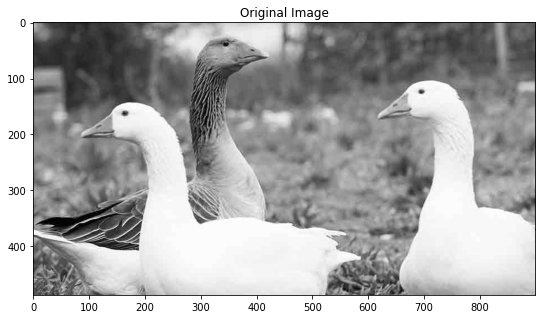

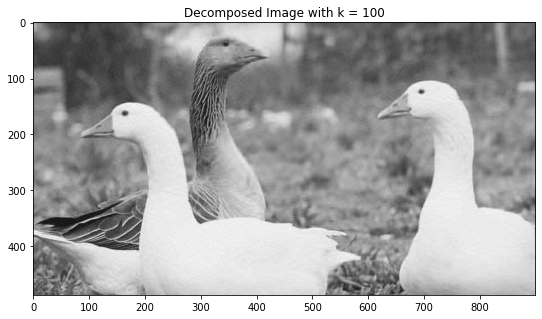

In [38]:
decompose_img('goose.jpg', k=100)    

#### Bisection method

In [88]:
def bisection_method(a, b, f, max_iters=100, tol=1e-4,):
    i = 0
    while i < max_iters:
        c = 0.5 * (a + b)
        fc = f(c)
        print('a =', a, 'b =', b)
        
        # check conversion.
        if b-a < tol or abs(fc) < tol:
            print('conversion at i =', i)
            break
            
        # update a or b    
        if fc < 0:
            a = c
        else:
            b = c
        
        i += 1
        
    if i == max_iters:
        print('"max_iters" reached before conversion, i =', i)
    return 0.5 * (a + b)

In [89]:
bisection_method(1, 2, lambda x: x**2 - 3)

a = 1 b = 2
a = 1.5 b = 2
a = 1.5 b = 1.75
a = 1.625 b = 1.75
a = 1.6875 b = 1.75
a = 1.71875 b = 1.75
a = 1.71875 b = 1.734375
a = 1.7265625 b = 1.734375
a = 1.73046875 b = 1.734375
a = 1.73046875 b = 1.732421875
a = 1.7314453125 b = 1.732421875
a = 1.73193359375 b = 1.732421875
a = 1.73193359375 b = 1.732177734375
conversion at i = 12


1.7320556640625

In [40]:
def f(x):
    return x**3 - x - 2

x0 = bisection_method(1, 2, f)
f(x0)

conversion at i = 14


7.795631350404619e-05

#### Fixed-point method

In [41]:
def fixed_point_method(g, x0, max_iters=100, tol=1e-4):
    x = x0
    x_prev = x0
    i = 0
    while i < max_iters:
        x = g(x)
        if abs(x - x_prev) < tol:
            print('conversion at i =', i)
            break
        x_prev = x
        i += 1
    
    if i == max_iters:
        print('"max_iters" reached before conversion, i =', i)
    return x

In [42]:
# f(x) = x - sin(x) - 0.5
g = lambda x: np.sin(x) + 0.5
print('fixed_point_method =', fixed_point_method(g, -1))
print('scipy.optimize.fsolve =', fsolve(lambda x: x - np.sin(x) - 0.5, -1))

conversion at i = 8
fixed_point_method = 1.497295173355198
scipy.optimize.fsolve = [1.49730039]


#### Newton-Raphson Method

In [43]:
def newton_raphson_method(init_val, f, f_, max_iters=100, tol=1e-4):
    x = init_val
    x_prev = init_val
    i = 0
    while i < max_iters:
        x = x - f(x) / f_(x)
        if abs(x - x_prev) < tol:
            print('conversion at i =', i)
            break
        x_prev = x
        i += 1
    
    if i == max_iters:
        print('"max_iters" reached before conversion, i =', i)
    return x

In [44]:
# Ex 1
f = lambda x: x**3 - 2 * x + 2
f_ = lambda x: 3 * x**2 - 2

print('newton_raphson_method =', newton_raphson_method(-2, f, f_))
print('scipy.optimize.fsolve =', fsolve(f, -1))

conversion at i = 3
newton_raphson_method = -1.7692923542386998
scipy.optimize.fsolve = [-1.76929235]


In [45]:
# Ex 2
f = lambda x: x**3 - x**2 - 15*x + 1
f_ = lambda x: 3*x**2 - 2*x - 15

print('newton_raphson_method =', newton_raphson_method(4.5, f, f_))
print('scipy.optimize.fsolve =', fsolve(f, 4.5))

conversion at i = 2
newton_raphson_method = 4.375753855705814
scipy.optimize.fsolve = [4.37575386]
